In [13]:
from google.colab import drive
drive.mount('/content/drive') #this works to conect the drive to the script itself being then able to acess files such as the data.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extração dos ficheiros zip

In [2]:
!unzip /content/drive/MyDrive/TESE/RioFatSegm.zip

Archive:  /content/drive/MyDrive/TESE/RioFatSegm.zip
  inflating: RioFatSegm/2016Rodrigues.pdf  
   creating: RioFatSegm/Dicom _ Treino/
   creating: RioFatSegm/Dicom _ Treino/ACel/
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0001_an.dcm  
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0002_an.dcm  
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0003_an.dcm  
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0004_an.dcm  
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0005_an.dcm  
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0006_an.dcm  
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0007_an.dcm  
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0008_an.dcm  
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0009_an.dcm  
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0010_an.dcm  
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0011_an.dcm  
  inflating: RioFatSegm/Dicom _ Treino/ACel/IM-0003-0012_an.dcm  
  inflating: RioFatSegm/Di

In [3]:
import glob
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from PIL import Image, ImageDraw
# example of converting an image with the Keras API
# example of saving an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

FUNÇÃO PARA EXTRAÇÃO DE MASCARAS

In [4]:
def convert_mask(img):
 mascara_azul=np.zeros((512,512))
 #mascara_verde=np.zeros((512,512))
#Y_fat_range[0]
#plt.imshow(Y_fat_range[0])
 for i in range(len(img[0,:,2])):
    for l in range(len(img[:,0,2])):
        if img[l,i,0]==0 and img[l,i,1]==0 and img[l,i,2]>0:
            mascara_azul[l,i]=1
        #if img[l,i,0]==0 and img[l,i,1]>0 and img[l,i,2]==0:
            #mascara_verde[l,i]=1
 return mascara_azul                #,mascara_verde           

FUNÇÃO PARA CONVERTER EM FORMA CONVEXA O PERICARDIO

In [5]:
def convex_hull_image(data):
    region = np.argwhere(data)
    hull = ConvexHull(region)
    verts = [(region[v,0], region[v,1]) for v in hull.vertices]
    img = Image.new('L', data.shape, 0)
    ImageDraw.Draw(img).polygon(verts, outline=1, fill=1)
    mask = np.array(img)
    
    return mask.T

Install Dicom

In [6]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.2 MB/s 


In [7]:
import pydicom as dicom

In [ ]:
path='/content/RioFatSegm/Dicom _ Treino/ACel/IM-0003-0001_an.dcm'
x=dicom.dcmread(path)

In [ ]:
print(x)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113704.1.111.3236.1399470293.15473
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7238010.5.0.3.5.4
(0002, 0013) Implementation Version Name         SH: 'OSIRIX'
(0002, 0016) Source Application Entity Title     AE: 'pacswebFIR'
(0002, 0100) Private Information Creator UID     UI: iMac-de-CDPI
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20140507'
(0008, 0013) Instance Creation Time       

/usr/local/lib/python3.7/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'iMac-de-CDPI'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


CRIAÇÃO E CONVERSÃO DAS DICOM ORIGINAIS EM FAT IMAGES PARA FAZER REGISTRATION

In [8]:
def min_max_norm(x):
  y = (x -np.min(x)) / (np.max(x) - np.min(x))
  return y

In [9]:
def convert_hu(dicom,min,max):
  dicom_hu = dicom.pixel_array * dicom.RescaleSlope + dicom.RescaleIntercept
  clipped_hu=np.zeros((512,512))
  #clipped_hu = np.clip(dicom_hu, min,max)
  for i in range(len(dicom_hu[0,:])):
    for l in range(len(dicom_hu[:,0])):
        if dicom_hu[l,i]>max or dicom_hu[l,i]<min :
            clipped_hu[l,i]=min
        else:
            clipped_hu[l,i]=dicom_hu[l,i]
  y = min_max_norm(clipped_hu)          
  return clipped_hu


Organizão e correspondência das FAT_IMAGES às respetivas máscaras (epicardio/pericardium)

In [14]:
X_train_fat=[]
Y_new=[]
epi_mask=[]
medi_mask=[]
convex_mask=[]
X_dicom=[]

#path_convex=[]
#path_fat=[]

#name_fat=[]
#num=[]
#path=[]


Y_new_PATH ='/content/RioFatSegm/Ground Truth - Fat Range/'
FAT_PATH ='/content/RioFatSegm/Fat Images/'
TRAIN_PATH ='/content/RioFatSegm/Dicom _ Treino/'

fat_tr=sorted(os.listdir(FAT_PATH))

for patient in fat_tr:
    n=0
    files=sorted(glob.glob(Y_new_PATH+patient+'/*.bmp'))
    
    for file in files:
        n=n+1
        #num.append(n)
        img =cv2.imread(file)
        Y_new.append(list(img))
        #name_fat.append(patient)
        #path.append(file)
        
        print(len(Y_new),file)
        
        imagem=np.array(list(img))
        epicardio_mask=convert_mask(imagem)
        
        if epicardio_mask.any() ==1:
            peri_convex_mask=convex_hull_image(epicardio_mask)
            convex_mask.append(list(peri_convex_mask))
            #path_convex.append(file)
            epi_mask.append(list(epicardio_mask))
            
            # save the image epicardio mask
            #img_epi = img_to_array(epicardio_mask)
            #epi_mask_path="/content/drive/MyDrive/TESE/RioFat/Epicardio/mask"
            #os.chdir(epi_mask_path)
            #save_img(str(patient)+'_'+str(n)+'_epi.jpg', img_epi)
            
            # save the image convex mask
            #img_conv = img_to_array(peri_convex_mask)
            #peri_mask_path="/content/drive/MyDrive/TESE/RioFat/Peri_conv/mask"
            #os.chdir(peri_mask_path)
            #save_img(str(patient)+'_'+str(n)+'_conv.jpg', img_conv)
            #print(len(epi_mask),file)
            
    files2=sorted(glob.glob(FAT_PATH+patient+'/*.BMP'))
    n=0
    for file2 in files2:
      n=n+1  
      if len(X_train_fat)<len(convex_mask):  # para convexa , senão mudar para Y_new
        img =cv2.imread(file2,0)
        X_train_fat.append(list(img))
        #path_fat.append(file2)
        
        # save the fat image 
        #epi_img_path="/content/drive/MyDrive/TESE/RioFat/Epicardio/images"
        #os.chdir(epi_img_path) 
        #img_fat = img_to_array(img)
        #save_img(str(patient)+'_'+str(n)+'_fat.jpg', img_fat)

    files3=sorted(glob.glob(TRAIN_PATH+patient+'/*.dcm'))
    n=0
    for file3 in files3 :
      n=n+1
      if len(X_dicom)<len(convex_mask):
        ds = dicom.dcmread(file3)
        img = ds.pixel_array
        #img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
        X_dicom.append(list(img))
        y=convert_hu(ds,-200,-30)
        # save the  dicom image 
        dicom_img_path="/content/drive/MyDrive/TESE/RioFat/Registration/DICOM_FAT"
        os.chdir(dicom_img_path) 
        img_dicom= img_to_array(y)
        save_img(str(patient)+'_'+str(n)+'_dicom_fat.png', img_dicom)  
        print(len(X_dicom),file3) 
        

1 /content/RioFatSegm/Ground Truth - Fat Range/ACel/001.bmp
2 /content/RioFatSegm/Ground Truth - Fat Range/ACel/002.bmp
3 /content/RioFatSegm/Ground Truth - Fat Range/ACel/003.bmp
4 /content/RioFatSegm/Ground Truth - Fat Range/ACel/004.bmp
5 /content/RioFatSegm/Ground Truth - Fat Range/ACel/005.bmp
6 /content/RioFatSegm/Ground Truth - Fat Range/ACel/006.bmp
7 /content/RioFatSegm/Ground Truth - Fat Range/ACel/007.bmp
8 /content/RioFatSegm/Ground Truth - Fat Range/ACel/008.bmp
9 /content/RioFatSegm/Ground Truth - Fat Range/ACel/009.bmp
10 /content/RioFatSegm/Ground Truth - Fat Range/ACel/010.bmp
11 /content/RioFatSegm/Ground Truth - Fat Range/ACel/011.bmp
12 /content/RioFatSegm/Ground Truth - Fat Range/ACel/012.bmp
13 /content/RioFatSegm/Ground Truth - Fat Range/ACel/013.bmp
14 /content/RioFatSegm/Ground Truth - Fat Range/ACel/014.bmp
15 /content/RioFatSegm/Ground Truth - Fat Range/ACel/015.bmp
16 /content/RioFatSegm/Ground Truth - Fat Range/ACel/016.bmp
17 /content/RioFatSegm/Ground Tru

Converter as imagens para array

In [15]:
X_train_fat=np.array(X_train_fat)
Y_new=np.array(Y_new)
epi_mask=np.array(epi_mask)
#medi_mask=np.array(medi_mask)
convex_mask=np.array(convex_mask)
X_dicom=np.array(X_dicom)
#path=np.array(path)
#path_convex=np.array(path_convex)
#path_fat=np.array(path_fat)


#name_fat=np.array(name_fat)
#num_fat=np.array(num)

Check se os shapes coincidem 

In [16]:
X_train_fat.shape[0]==epi_mask.shape[0]==convex_mask.shape[0]==X_dicom.shape[0]

True

In [17]:
X_train_fat.shape

(757, 512, 512)

In [18]:
X_dicom.shape

(757, 512, 512)

GUARDAR COMO ARRAY PARA NÃO FAZER TUDO NOVAMENTE

In [19]:
from numpy import asarray
from numpy import save

array_path="/content/drive/MyDrive/TESE/RioFat/arrays"
os.chdir(array_path) 
#save('convex_mask.npy', convex_mask)

In [20]:
#save('fat_images_fcon.npy', X_train_fat)

In [ ]:
#save('epi_mask_fat.npy', epi_mask)

In [ ]:
#save('dicom_images.npy', X_dicom)

Testar load

In [21]:
# load numpy array from npy file
import os

from numpy import load
array_path="/content/drive/MyDrive/TESE/RioFat/arrays"
os.chdir(array_path) 

mascaras_epi=load('epi_mask_fat.npy')
mascaras_peri=load('convex_mask.npy')
fat_images=load('fat_images_fcon.npy')
dicom_images=load('dicom_images.npy')

In [22]:
mascaras_epi.shape

(757, 512, 512)

In [23]:
fat_images.shape

(757, 512, 512)

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Dicom image')

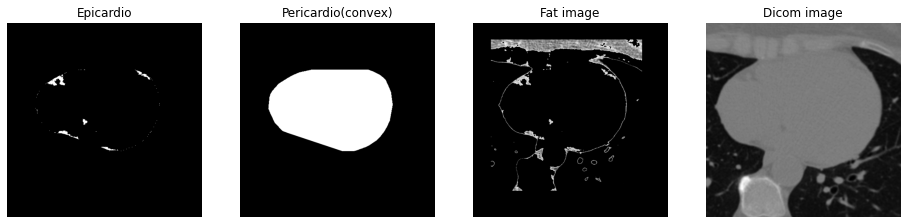

In [ ]:
plt.figure(figsize=(16,16))
plt.subplot(1,4,1)
plt.imshow(mascaras_epi[356],cmap='gray')
plt.axis('off')
plt.title('Epicardio')
plt.subplot(1,4,2)
plt.imshow(mascaras_peri[356],cmap='gray')
plt.axis('off')
plt.title('Pericardio(convex)')
plt.subplot(1,4,3)
plt.imshow(fat_images[356])
plt.axis('off')
plt.title('Fat image')
plt.subplot(1,4,4)
plt.imshow(dicom_images[356],cmap='gray')
plt.axis('off')
plt.title('Dicom image')